# Baseline XGBoost Classifier - Soccer O/U 2.5 Goals Prediction

**Objective**: Build and evaluate a baseline XGBoost classifier using core soccer match features to predict Over/Under 2.5 goals.

**Tasks**:
- Load baseline preprocessed data
- Build baseline XGBoost classifier  
- Train and validate model
- Hyperparameter tuning
- Feature importance analysis
- Learning curves
- Performance comparison (tuned vs untuned)
- XGBoost vs Random Forest comparison

## 1. Setup and Data Loading

### 1.1 Import Libraries

In [77]:
# Core libraries
import pandas as pd
import numpy as np
import pickle
import time
import warnings
warnings.filterwarnings('ignore', category=Warning) # Suppress convergence warnings from Gaussian Process


#learning curve for baseline model
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit



# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler

# XGBoost
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# Machine Learning
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve, ShuffleSplit
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)

# Bayesian Optimization
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### 1.2 Evaluation function

In [78]:
# Function to calculate comprehensive metrics
def evaluate_model(y_true, y_pred, y_pred_proba, model_name="Model"):
    """Calculate comprehensive classification metrics"""
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred_proba)
    }
    
    print(f"\n📈 {model_name} Performance Metrics:")
    print("=" * 50)
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    
    return metrics

### 1.3 Load Baseline Preprocessed Data

In [79]:
# Load the baseline preprocessed data

with open('processed/baseline_preprocessed.pkl', 'rb') as f:
    baseline_data = pickle.load(f)

# Extract all datasets including validation
X_train_baseline = baseline_data['X_train']
X_val_baseline = baseline_data['X_val']
X_test_baseline = baseline_data['X_test'] 
y_train = baseline_data['y_train']
y_val = baseline_data['y_val']
y_test = baseline_data['y_test']

print(f"\n📊 Dataset Shapes:")
print(f"Training set: {X_train_baseline.shape}")
print(f"Validation set: {X_val_baseline.shape}")
print(f"Test set: {X_test_baseline.shape}")
print(f"Features: {X_train_baseline.shape[1]}")

print(f"\n🎯 Target Distribution:")
print(f"Training - Over 2.5: {y_train.mean():.2%}")
print(f"Validation - Over 2.5: {y_val.mean():.2%}")
print(f"Test - Over 2.5: {y_test.mean():.2%}")


# Display data split summary
total_samples = len(y_train) + len(y_val) + len(y_test)
print(f"\n📈 Data Split Summary:")
print(f"Total samples: {total_samples:,}")
print(f"Training: {len(y_train):,} ({len(y_train)/total_samples:.1%})")
print(f"Validation: {len(y_val):,} ({len(y_val)/total_samples:.1%})")
print(f"Test: {len(y_test):,} ({len(y_test)/total_samples:.1%})")


📊 Dataset Shapes:
Training set: (20940, 344)
Validation set: (7277, 344)
Test set: (14376, 344)
Features: 344

🎯 Target Distribution:
Training - Over 2.5: 48.97%
Validation - Over 2.5: 49.10%
Test - Over 2.5: 51.93%

📈 Data Split Summary:
Total samples: 42,593
Training: 20,940 (49.2%)
Validation: 7,277 (17.1%)
Test: 14,376 (33.8%)


## 2 Modeling

### 2.1 Baseline model

In [80]:
# Create baseline XGBoost classifier with default parameters

# Initialize XGBoost with basic parameters
xgb_baseline = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0  # Suppress training output
)


# Train the baseline XGBoost model
xgb_baseline.fit(X_train_baseline, y_train)


# Make predictions on validation set
y_val_pred_baseline = xgb_baseline.predict(X_val_baseline)
y_val_pred_proba_baseline = xgb_baseline.predict_proba(X_val_baseline)[:, 1]


# Evaluate baseline model
baseline_metrics = evaluate_model(
    y_val, y_val_pred_baseline, y_val_pred_proba_baseline, 
    "Baseline XGBoost (Validation)"
)



📈 Baseline XGBoost (Validation) Performance Metrics:
Accuracy:  0.5065
Precision: 0.4979
Recall:    0.6037
F1-Score:  0.5457
ROC-AUC:   0.5125


## 2.2 Hyperparameter Optimization with Optuna

#### 2.2.1 Definition of optimized parameters and training training-validation function

In [81]:





def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization
    Returns: ROC-AUC score to maximize
    """
    
    # Define hyperparameter search space
    params = {
        'objective': 'binary:logistic',
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbosity': 0,
        
        # Tree structure parameters - adjusted for high dimensions (344+ features)
        'max_depth': trial.suggest_int('max_depth', 4, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 20),
        
        # Sampling parameters - crucial for high dimensions
        'subsample': trial.suggest_float('subsample', 0.7, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 0.9),
        
        # Boosting parameters
        'n_estimators': trial.suggest_int('n_estimators', 100, 4000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.8, log=True),
        
        # Regularization parameters - stronger for high dimensions
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 20.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 50.0),
        
        # Advanced parameters
        'gamma': trial.suggest_float('gamma', 0.1, 10.0),
    }
    
    # Create and train model
    model = xgb.XGBClassifier(**params)
    model.fit(X_train_baseline, y_train)
    
    # Predict on validation set
    y_pred_proba = model.predict_proba(X_val_baseline)[:, 1]
    
    # Return ROC-AUC score (higher is better)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    return roc_auc



#### 2.2.2 Running optuna optimization with 150 trials

In [82]:
### 3.3 Run Hyperparameter Optimization

# Create study with TPE sampler for efficient search
study = optuna.create_study(
    direction='maximize',  # We want to maximize ROC-AUC
    sampler=TPESampler(seed=RANDOM_STATE),
    study_name='xgboost_soccer_prediction'
)

# Record start time
start_time = time.time()

# Run optimization with more trials for high-dimensional space
N_TRIALS = 150  # More trials needed for complex parameter space with 344+ features
print(f"🚀 Running {N_TRIALS} trials for high-dimensional optimization...")

study.optimize(objective, n_trials=N_TRIALS)

# Calculate optimization time
optimization_time = time.time() - start_time

print(f"✅ Optimization completed in {optimization_time:.1f} seconds")
print(f"📊 Best ROC-AUC: {study.best_value:.6f}")
print(f"🏆 Best trial: #{study.best_trial.number}")


[I 2025-11-12 12:54:26,496] A new study created in memory with name: xgboost_soccer_prediction


🚀 Running 150 trials for high-dimensional optimization...


[I 2025-11-12 12:54:28,817] Trial 0 finished with value: 0.5826913317967308 and parameters: {'max_depth': 14, 'min_child_weight': 20, 'subsample': 0.8829984854528512, 'colsample_bytree': 0.5190609389379257, 'colsample_bylevel': 0.22481491235394924, 'n_estimators': 700, 'learning_rate': 0.006714184244399761, 'reg_alpha': 17.33690530092121, 'reg_lambda': 30.45463557541723, 'gamma': 7.10991852018085}. Best is trial 0 with value: 0.5826913317967308.
[I 2025-11-12 12:54:31,690] Trial 1 finished with value: 0.5805163924417533 and parameters: {'max_depth': 4, 'min_child_weight': 20, 'subsample': 0.9081106602001054, 'colsample_bytree': 0.24863737747479334, 'colsample_bylevel': 0.24545997376568052, 'n_estimators': 800, 'learning_rate': 0.023418356423825146, 'reg_alpha': 10.542652989481532, 'reg_lambda': 22.165305913463673, 'gamma': 2.983168487960615}. Best is trial 0 with value: 0.5826913317967308.
[I 2025-11-12 12:55:05,319] Trial 2 finished with value: 0.5546828294038744 and parameters: {'max

✅ Optimization completed in 899.6 seconds
📊 Best ROC-AUC: 0.587019
🏆 Best trial: #141


#### 2.2.3 Best parameters according to optuna

In [83]:
print("📋 Best hyperparameters:")
for param, value in study.best_params.items():
    print(f"   {param}: {value}")

📋 Best hyperparameters:
   max_depth: 13
   min_child_weight: 7
   subsample: 0.8581858884292934
   colsample_bytree: 0.5942246346988888
   colsample_bylevel: 0.2586626338562513
   n_estimators: 1800
   learning_rate: 0.047840936281696375
   reg_alpha: 14.233226144057365
   reg_lambda: 26.857296310912346
   gamma: 6.304060740625535


## 2.2 Hyperparameter Optimization with manual Bayesian Optimization

In [84]:


# --------------------------------------------
#  Define objective function (same as Optuna)
# --------------------------------------------
def evaluate_xgb_manual(params):
    """Train XGBoost and evaluate ROC-AUC on validation - matches Optuna objective."""
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0,
        # Parameters in same order as bounds array
        max_depth=int(params[0]),
        min_child_weight=int(params[1]),
        subsample=params[2],
        colsample_bytree=params[3],
        colsample_bylevel=params[4],
        n_estimators=int(params[5]),
        learning_rate=params[6],
        reg_alpha=params[7],
        reg_lambda=params[8],
        gamma=params[9]
    )

    model.fit(X_train_baseline, y_train)
    y_pred_val = model.predict_proba(X_val_baseline)[:, 1]
    auc = roc_auc_score(y_val, y_pred_val)
    # We minimize 1 - AUC (same as maximizing AUC)
    return 1 - auc

# --------------------------------------------
#  Define search space bounds (matching Optuna exactly)
# --------------------------------------------
param_bounds = np.array([
    [4, 30],         # max_depth: 4-30
    [3, 20],         # min_child_weight: 3-20
    [0.7, 0.95],     # subsample: 0.7-0.95
    [0.1, 0.8],      # colsample_bytree: 0.1-0.8
    [0.1, 0.9],      # colsample_bylevel: 0.1-0.9
    [100, 4000],     # n_estimators: 100-4000
    [0.005, 0.8],    # learning_rate: 0.005-0.8
    [0.1, 20.0],     # reg_alpha: 0.1-20.0
    [1.0, 50.0],     # reg_lambda: 1.0-50.0
    [0.1, 10.0],     # gamma: 0.1-10.0
])

n_params = param_bounds.shape[0]

# --------------------------------------------
#  Initialize samples (random warm-up)
# --------------------------------------------
np.random.seed(RANDOM_STATE)
N_INIT = 15  # More initial samples for 10-dimensional space


X_samples = np.random.uniform(param_bounds[:, 0], param_bounds[:, 1], size=(N_INIT, n_params))
Y_samples = np.array([evaluate_xgb_manual(x) for x in X_samples])

# --------------------------------------------
#  Fit Gaussian Process surrogate
# --------------------------------------------
kernel = Matern(length_scale=1.0, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=RANDOM_STATE)

# Scaler helps GP fit parameters of different magnitudes 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_samples)
gp.fit(X_scaled, Y_samples)

# --------------------------------------------
#  Acquisition function (Upper Confidence Bound)
# --------------------------------------------
def acquisition_ucb(X, model, kappa=2.0):
    """Upper Confidence Bound acquisition function"""
    mu, sigma = model.predict(X, return_std=True)
    return mu - kappa * sigma  # minimizing (1 - AUC)

def propose_next(model, bounds, n_candidates=3000):
    """Propose next point to evaluate"""
    candidates = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_candidates, bounds.shape[0]))
    candidates_scaled = scaler.transform(candidates)
    acq_vals = acquisition_ucb(candidates_scaled, model)
    best_idx = np.argmin(acq_vals)
    return candidates[best_idx].reshape(1, -1), np.min(acq_vals)

# --------------------------------------------
#  Iterative Bayesian Optimization loop
# --------------------------------------------
N_ITER = 150  # More iterations to match Optuna's exploration capacity
history_best = [np.min(Y_samples)]

print(f"\n🚀 Starting Bayesian Optimization with {N_ITER} iterations...")
start_time = time.time()

for i in range(N_ITER):
    # Propose next point
    x_next, acq_val = propose_next(gp, param_bounds)
    y_next = evaluate_xgb_manual(x_next[0])
    
    # Update datasets
    X_samples = np.vstack([X_samples, x_next])
    Y_samples = np.hstack([Y_samples, y_next])

    # Refit Gaussian Process
    X_scaled = scaler.fit_transform(X_samples)
    gp.fit(X_scaled, Y_samples)

    # Track progress
    history_best.append(np.min(Y_samples))
    current_best_auc = 1 - np.min(Y_samples)
    
    if (i + 1) % 10 == 0 or i < 5:  # Print progress every 10 iterations
        print(f"Iteration {i+1:02d}: Best AUC = {current_best_auc:.5f}")

optimization_time = time.time() - start_time

# --------------------------------------------
#  Final results and comparison
# --------------------------------------------
best_idx = np.argmin(Y_samples)
best_params_array = X_samples[best_idx]
best_auc = 1 - Y_samples[best_idx]



# Create parameter dictionary in same format as Optuna
param_names = ["max_depth", "min_child_weight", "subsample", "colsample_bytree",
               "colsample_bylevel", "n_estimators", "learning_rate", "reg_alpha",
               "reg_lambda", "gamma"]

# Convert to dictionary format matching Optuna output
manual_bo_params = {}
for i, name in enumerate(param_names):
    if name in ["max_depth", "min_child_weight", "n_estimators"]:
        manual_bo_params[name] = int(best_params_array[i])
    else:
        manual_bo_params[name] = float(best_params_array[i])

print(f"\n📋 Best hyperparameters found:")
for name, val in manual_bo_params.items():
    if isinstance(val, int):
        print(f"  {name:18}: {val}")
    else:
        print(f"  {name:18}: {val:.4f}")



print(f"\n🏆 Manual Bayesian Optimization Results:")
print(f"⏱️  Optimization time: {optimization_time:.1f} seconds")
print(f"🎯 Best validation AUC: {best_auc:.6f}")
print(f"📊 Total evaluations: {len(Y_samples)}")



🚀 Starting Bayesian Optimization with 150 iterations...
Iteration 01: Best AUC = 0.58414
Iteration 02: Best AUC = 0.58414
Iteration 03: Best AUC = 0.58414
Iteration 04: Best AUC = 0.58414
Iteration 05: Best AUC = 0.58414
Iteration 10: Best AUC = 0.58414
Iteration 20: Best AUC = 0.58414
Iteration 30: Best AUC = 0.58488
Iteration 40: Best AUC = 0.58488
Iteration 50: Best AUC = 0.58488
Iteration 60: Best AUC = 0.58548
Iteration 70: Best AUC = 0.58548
Iteration 80: Best AUC = 0.58548
Iteration 90: Best AUC = 0.58696
Iteration 100: Best AUC = 0.58696
Iteration 110: Best AUC = 0.58696
Iteration 120: Best AUC = 0.58696
Iteration 130: Best AUC = 0.58696
Iteration 140: Best AUC = 0.58696
Iteration 150: Best AUC = 0.58696

📋 Best hyperparameters found:
  max_depth         : 21
  min_child_weight  : 10
  subsample         : 0.8987
  colsample_bytree  : 0.2428
  colsample_bylevel : 0.2555
  n_estimators      : 3117
  learning_rate     : 0.0220
  reg_alpha         : 0.4974
  reg_lambda        : 42

## 2.3 Comparison of optuna vs manual

#### 2.3.1 Best parameters according to both approaches

In [85]:

# Extract best parameters from Optuna study
optuna_params = study.best_params
optuna_auc = study.best_value

print(f"\n📊 Comparison of Best Hyperparameters:")
print(f"{'Parameter':<18} {'Optuna':<15}        {'Manual BO':<15}")
print("-" * 50)

for param in param_names:
    optuna_val = optuna_params.get(param, 'N/A')
    manual_val = manual_bo_params.get(param, 'N/A')
    
    if isinstance(manual_val, int):
        print(f"{param:<18} {optuna_val:<15}              {manual_val:<15}")
    else:
        
        print(f"{param:<18} {optuna_val:<15}         {manual_val:.4f}")

print(f"\n🎯 Best AUC Comparison:")
print(f"Optuna AUC:    {optuna_auc:.6f}")
print(f"Manual BO AUC: {best_auc:.6f}")
print(f"Difference:    {abs(optuna_auc - best_auc):.6f}")




📊 Comparison of Best Hyperparameters:
Parameter          Optuna                 Manual BO      
--------------------------------------------------
max_depth          13                           21             
min_child_weight   7                            10             
subsample          0.8581858884292934         0.8987
colsample_bytree   0.5942246346988888         0.2428
colsample_bylevel  0.2586626338562513         0.2555
n_estimators       1800                         3117           
learning_rate      0.047840936281696375         0.0220
reg_alpha          14.233226144057365         0.4974
reg_lambda         26.857296310912346         42.9873
gamma              6.304060740625535         9.6852

🎯 Best AUC Comparison:
Optuna AUC:    0.587019
Manual BO AUC: 0.586959
Difference:    0.000061


## 2.4 Training Models with optimized parameters 

In [86]:


# Model trained with Optuna best parameters
xgb_optuna = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
    **optuna_params
)

xgb_optuna.fit(X_train_baseline, y_train)
y_pred_val_optuna = xgb_optuna.predict_proba(X_val_baseline)[:, 1]
auc_optuna = roc_auc_score(y_val, y_pred_val_optuna)
print(f"✅ Optuna model AUC: {auc_optuna:.6f}")

# Model trained with Manual Bayesian Optimization best parameters  
xgb_manual = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
    **manual_bo_params
)

xgb_manual.fit(X_train_baseline, y_train)
y_pred_val_manual = xgb_manual.predict_proba(X_val_baseline)[:, 1]
auc_manual = roc_auc_score(y_val, y_pred_val_manual)
print(f"✅ Manual BO model AUC: {auc_manual:.6f}")

print(f"\n📊 Final Validation Results:")
print(f"Baseline XGBoost:     {baseline_metrics['roc_auc']:.6f}")
print(f"Optuna Optimized:     {auc_optuna:.6f}")
print(f"Manual BO Optimized:  {auc_manual:.6f}")



✅ Optuna model AUC: 0.587019
✅ Manual BO model AUC: 0.586959

📊 Final Validation Results:
Baseline XGBoost:     0.512456
Optuna Optimized:     0.587019
Manual BO Optimized:  0.586959


# 3 Analysis

## 3.1 Feature importance in all three models

<Figure size 1200x800 with 0 Axes>

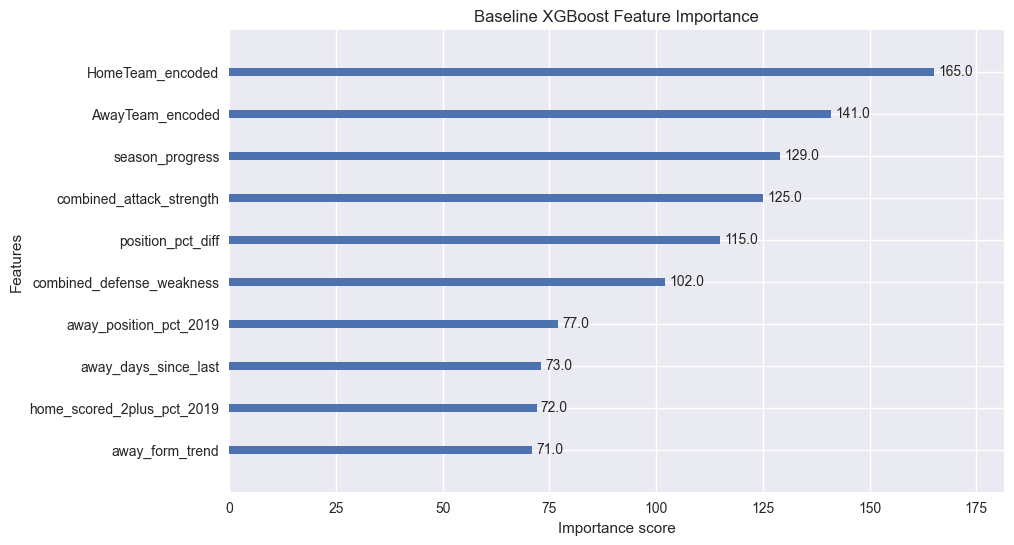

<Figure size 1200x800 with 0 Axes>

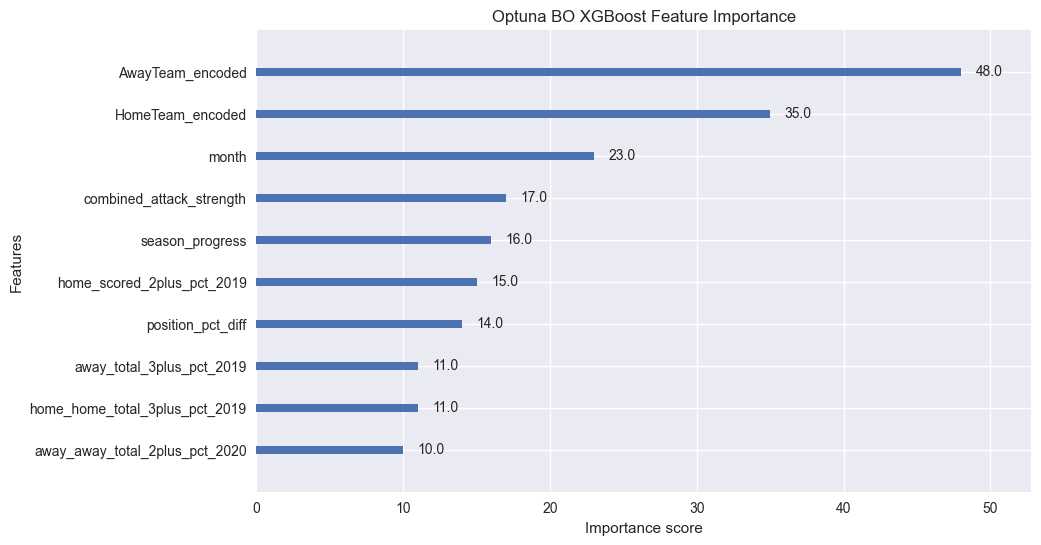

<Figure size 1200x800 with 0 Axes>

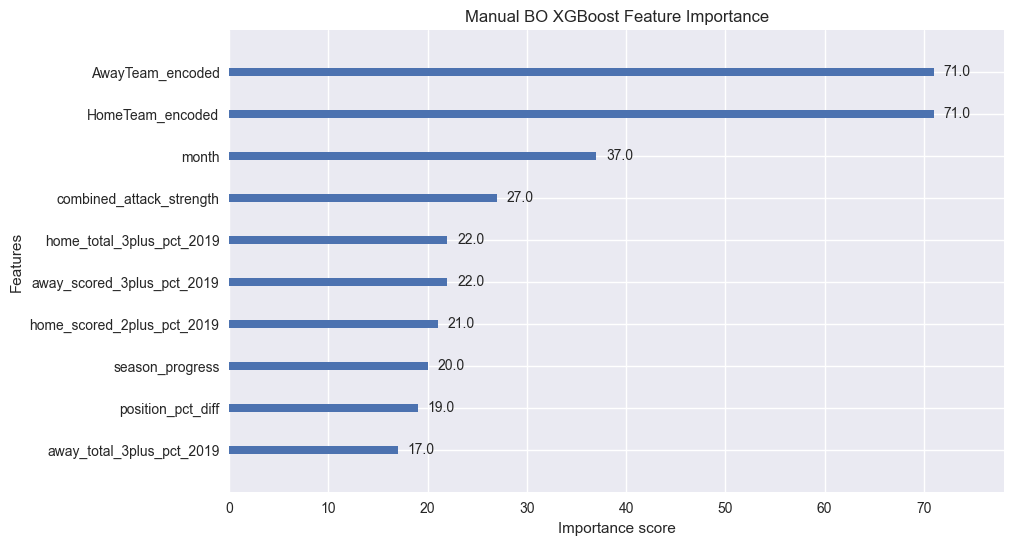

In [87]:


# Plot feature importance for baseline model
plt.figure(figsize=(12, 8))
plot_importance(xgb_baseline, max_num_features=10)
plt.title("Baseline XGBoost Feature Importance")
plt.show()


# Plot feature importance for optuna optimized model
plt.figure(figsize=(12, 8))
plot_importance(xgb_optuna, max_num_features=10)
plt.title("Optuna BO XGBoost Feature Importance")
plt.show()


# Plot feature importance for bayessian optimized model
plt.figure(figsize=(12, 8))
plot_importance(xgb_manual, max_num_features=10)
plt.title("Manual BO XGBoost Feature Importance")
plt.show()


## 3.2 learning curve for all three models

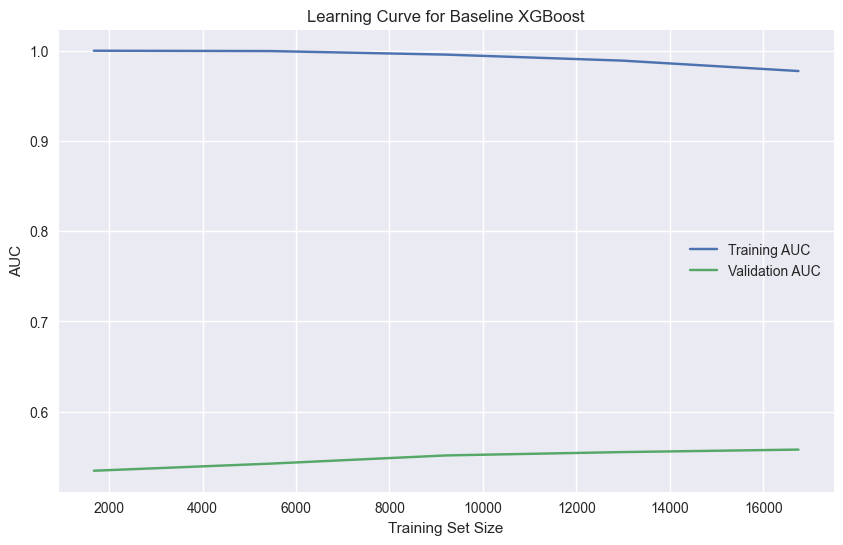

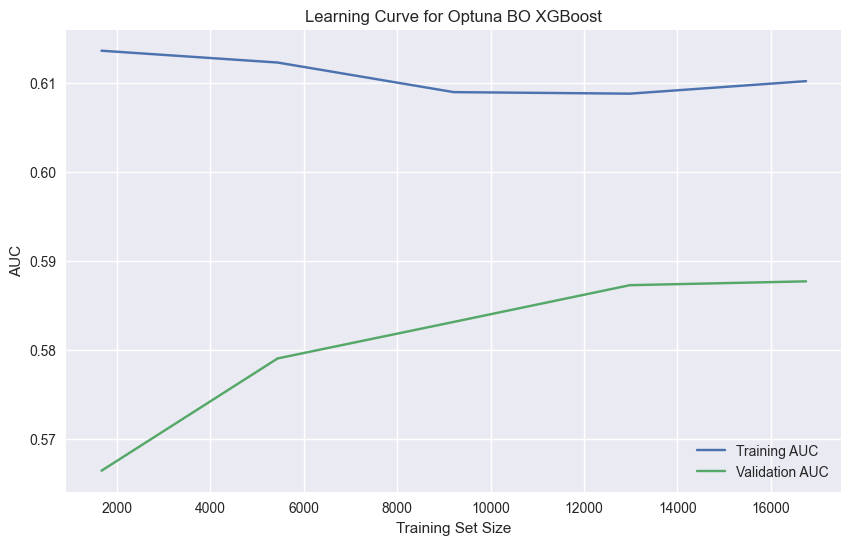

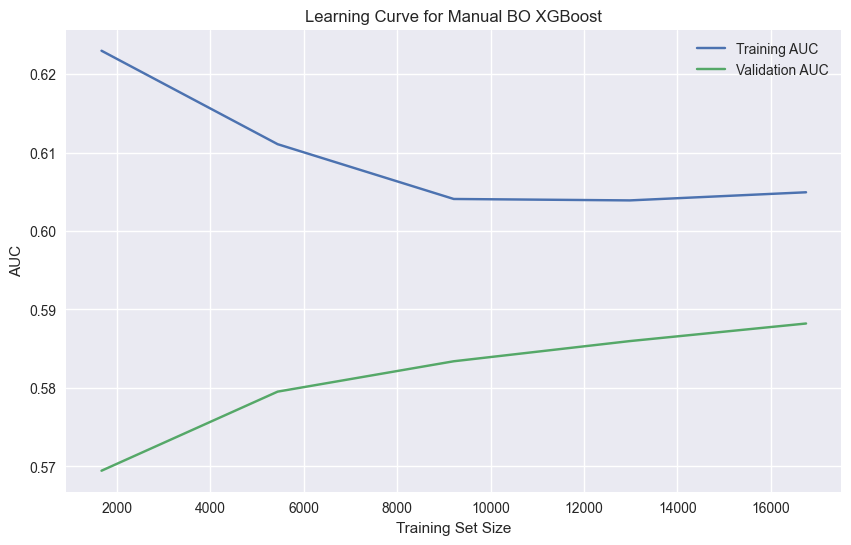

In [88]:


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(xgb_baseline, X_train_baseline, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training AUC')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation AUC')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.legend()
plt.title('Learning Curve for Baseline XGBoost')
plt.show()


#learning curve for optuna bo model
train_sizes, train_scores, test_scores = learning_curve(xgb_optuna, X_train_baseline, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training AUC')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation AUC')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.legend()
plt.title('Learning Curve for Optuna BO XGBoost')
plt.show()

#learning curve for manual bo model
train_sizes, train_scores, test_scores = learning_curve(xgb_manual, X_train_baseline, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training AUC')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation AUC')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.legend()
plt.title('Learning Curve for Manual BO XGBoost')
plt.show()

## 3.3 test_set prediction for both optimized models and baseline

In [89]:



# Model trained with baseline parameters
y_pred_test_baseline = xgb_baseline.predict_proba(X_test_baseline)[:, 1]
auc_baseline_test = roc_auc_score(y_test, y_pred_test_baseline)
print(f"✅ Baseline model TEST AUC: {auc_baseline_test:.6f}")


# Model trained with Optuna best parameters
y_pred_test_optuna = xgb_optuna.predict_proba(X_test_baseline)[:, 1]
auc_optuna_test = roc_auc_score(y_test, y_pred_test_optuna)
print(f"✅ Optuna model TEST AUC: {auc_optuna_test:.6f}")

# Model trained with manual Bayesian Optimization best parameters
y_pred_test_manual = xgb_manual.predict_proba(X_test_baseline)[:, 1]  
auc_manual_test = roc_auc_score(y_test, y_pred_test_manual)  
print(f"✅ Manual BO model TEST AUC: {auc_manual_test:.6f}")


✅ Baseline model TEST AUC: 0.523045
✅ Optuna model TEST AUC: 0.566055
✅ Manual BO model TEST AUC: 0.567013


## 3.4 Comprehensive Test Set Evaluation

In [90]:


# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_test_optuna_binary = (y_pred_test_optuna >= 0.5).astype(int)
y_pred_test_manual_binary = (y_pred_test_manual >= 0.5).astype(int) 
y_pred_test_baseline_binary = (y_pred_test_baseline >= 0.5).astype(int)



print("📊 TEST SET PERFORMANCE COMPARISON")
print("=" * 60)

print("\n🎯 OPTUNA OPTIMIZED MODEL:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test_optuna_binary):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test_optuna_binary):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test_optuna_binary):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test_optuna_binary):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_test_optuna):.4f}")

print("\n🔧 MANUAL BAYESIAN OPTIMIZED MODEL:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test_manual_binary):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test_manual_binary):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test_manual_binary):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test_manual_binary):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_test_manual):.4f}")

print("\n📊 BASELINE MODEL:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test_baseline_binary):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test_baseline_binary):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test_baseline_binary):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test_baseline_binary):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_test_baseline):.4f}")


# Confusion Matrices
print("\n🔢 CONFUSION MATRICES:")
print("\nOptuna Model:")
print(confusion_matrix(y_test, y_pred_test_optuna_binary))
print("\nManual BO Model:")
print(confusion_matrix(y_test, y_pred_test_manual_binary))
print("\nBaseline Model:")
print(confusion_matrix(y_test, y_pred_test_baseline_binary))







📊 TEST SET PERFORMANCE COMPARISON

🎯 OPTUNA OPTIMIZED MODEL:
Accuracy:  0.5486
Precision: 0.5678
Recall:    0.5472
F1-Score:  0.5573
ROC-AUC:   0.5661

🔧 MANUAL BAYESIAN OPTIMIZED MODEL:
Accuracy:  0.5472
Precision: 0.5662
Recall:    0.5468
F1-Score:  0.5564
ROC-AUC:   0.5670

📊 BASELINE MODEL:
Accuracy:  0.5188
Precision: 0.5329
Recall:    0.5936
F1-Score:  0.5616
ROC-AUC:   0.5230

🔢 CONFUSION MATRICES:

Optuna Model:
[[3802 3109]
 [3380 4085]]

Manual BO Model:
[[3784 3127]
 [3383 4082]]

Baseline Model:
[[3027 3884]
 [3034 4431]]


## 3.5 Classification Report by Country

In [91]:
# which countries we have based on division prefixes
print("🌍 CLASSIFICATION REPORT BY COUNTRY")
print("=" * 60)

# Extract country information from division columns
div_columns = [col for col in X_test_baseline.columns if col.startswith('Div_')]
print(f"Found {len(div_columns)} division columns")

# Get the active divisions for each match (where value = 1)
countries_data = []
for idx in range(len(X_test_baseline)):
    active_divs = [col.replace('Div_', '') for col in div_columns if X_test_baseline.iloc[idx][col] == 1]
    if active_divs:
        countries_data.append(active_divs[0])  # Take the first (should be only one)
    else:
        countries_data.append('Unknown')

# Create a mapping of common division codes to countries
country_mapping = {
    'B1': 'Belgium', 'D1': 'Germany', 'D2': 'Germany',
    'E0': 'England', 'E1': 'England', 'E2': 'England', 'E3': 'England', 'E4': 'England',
    'F1': 'France', 'F2': 'France',
    'G1': 'Greece', 'I1': 'Italy', 'I2': 'Italy',
    'N1': 'Netherlands', 'P1': 'Portugal',
    'SC0': 'Scotland', 'SC1': 'Scotland', 'SC2': 'Scotland', 'SC3': 'Scotland', 'SC4': 'Scotland',
    'SP1': 'Spain', 'SP2': 'Spain', 'T1': 'Turkey'
}

# Map division codes to country names
countries = [country_mapping.get(div, div) for div in countries_data]

# Get unique countries and their counts
country_counts = pd.Series(countries).value_counts()
print(f"\n📊 Matches per Country:")
for country, count in country_counts.items():
    print(f"   {country}: {count:,} matches")

print(f"\n🎯 CLASSIFICATION REPORTS BY COUNTRY:")
print("=" * 60)

# Generate classification report for each country with sufficient samples
min_samples = 50  # Minimum samples needed for meaningful report
significant_countries = country_counts[country_counts >= min_samples].index

for country in significant_countries:
    # Get indices for this country
    country_mask = pd.Series(countries) == country
    country_indices = country_mask[country_mask].index
    
    # Extract predictions and true values for this country
    y_true_country = y_test.iloc[country_indices]
    
    # Use the best performing model (Optuna optimized)
    y_pred_country = y_pred_test_optuna_binary[country_indices]
    y_pred_proba_country = y_pred_test_optuna[country_indices]
    
    print(f"\n🏴 {country.upper()} ({len(country_indices)} matches)")
    print("-" * 40)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_country, y_pred_country)
    precision = precision_score(y_true_country, y_pred_country, zero_division=0)
    recall = recall_score(y_true_country, y_pred_country, zero_division=0)
    f1 = f1_score(y_true_country, y_pred_country, zero_division=0)
    roc_auc = roc_auc_score(y_true_country, y_pred_proba_country)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    
    print(f"\nDetailed Classification Report:")
    
    # Get classification report as dictionary to customize output
    report_dict = classification_report(y_true_country, y_pred_country, 
                                      target_names=['Under 2.5', 'Over 2.5'], 
                                      zero_division=0, output_dict=True)
    
    # Print only the class-specific metrics (exclude summary rows)
    print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<8}")
    print("-" * 50)
    
    for class_name in ['Under 2.5', 'Over 2.5']:
        if class_name in report_dict:
            metrics = report_dict[class_name]
            print(f"{class_name:<12} {metrics['precision']:<10.2f} {metrics['recall']:<10.2f} {metrics['f1-score']:<10.2f} {int(metrics['support']):<8}")
    
    # Show actual vs predicted distribution
    actual_over = y_true_country.mean()
    predicted_over = pd.Series(y_pred_country).mean()
    print(f"Actual Over 2.5: {actual_over:.2%}")
    print(f"Predicted Over 2.5: {predicted_over:.2%}")

# Summary comparison across countries
print(f"\n📈 COUNTRY PERFORMANCE SUMMARY:")
print("-" * 60)
print(f"{'Country':<12} {'Samples':<8} {'Accuracy':<10} {'ROC-AUC':<10} {'Over 2.5%':<10}")
print("-" * 60)

for country in significant_countries:
    country_mask = pd.Series(countries) == country
    country_indices = country_mask[country_mask].index
    
    y_true_country = y_test.iloc[country_indices]
    y_pred_country = y_pred_test_optuna_binary[country_indices]
    y_pred_proba_country = y_pred_test_optuna[country_indices]
    
    accuracy = accuracy_score(y_true_country, y_pred_country)
    roc_auc = roc_auc_score(y_true_country, y_pred_proba_country)
    actual_over = y_true_country.mean()
    
    print(f"{country:<12} {len(country_indices):<8} {accuracy:<10.4f} {roc_auc:<10.4f} {actual_over:<10.2%}")



🌍 CLASSIFICATION REPORT BY COUNTRY
Found 21 division columns

📊 Matches per Country:
   England: 4,072 matches
   Spain: 1,684 matches
   Scotland: 1,536 matches
   Italy: 1,520 matches
   France: 1,297 matches
   Germany: 1,224 matches
   Turkey: 722 matches
   Belgium: 624 matches
   Netherlands: 612 matches
   Portugal: 612 matches
   Greece: 473 matches

🎯 CLASSIFICATION REPORTS BY COUNTRY:

🏴 ENGLAND (4072 matches)
----------------------------------------
Accuracy:  0.5410
Precision: 0.5657
Recall:    0.4881
F1-Score:  0.5241
ROC-AUC:   0.5548

Detailed Classification Report:
Class        Precision  Recall     F1-Score   Support 
--------------------------------------------------
Under 2.5    0.52       0.60       0.56       1964    
Over 2.5     0.57       0.49       0.52       2108    
Actual Over 2.5: 51.77%
Predicted Over 2.5: 44.67%

🏴 SPAIN (1684 matches)
----------------------------------------
Accuracy:  0.5891
Precision: 0.6194
Recall:    0.2196
F1-Score:  0.3242
ROC-AUC: